# Descriptive Data Analysis

1. How many articles there are, how many paths
2. Histograms of the links from each article (for example, how many articles have 20 links, etc)
3. Average distance from one article to any other article
4. Histogram of the number of games at each point in time
5. Categories of targets in unfinished games
6. Classify how many times each word appears in the games (we could also do a histogram with that)

In [19]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from networkx.drawing.nx_pydot import graphviz_layout

In [5]:
wikispeedia= nx.read_edgelist('datasets/wikispeedia_paths-and-graph/links.tsv', 
                                    create_using=nx.DiGraph)
paths_finished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', skiprows=15, 
                   names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "rating"])
paths_unfinished = pd.read_csv('datasets/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', skiprows=16,
                               names=['hashedIpAddress', 'timestamp', "durationInSec", 'path', "target", "type"])

## 1. How many: articles, links, finished games, unfinished games?

In [6]:
print("There are", len(wikispeedia.nodes), "articles in the dataset.")
print("There are", len(wikispeedia.edges), "links/paths.")
print("There are", paths_finished.shape[0], "finished games.")
print("There are", paths_unfinished.shape[0], "unfinished games.")

There are 4592 articles in the dataset.
There are 119882 links/paths.
There are 51318 finished games.
There are 24875 unfinished games.


In [ ]:
unique_paths = paths_finished['path'].unique()
print('There are', len(unique_paths), 'unique finshed paths.')

## 2. Degree of a Node
The degree of a node is the number of edges/links it has. We plot a complementary cumulative distribution function (CCDF) of degree for each article/node.

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': 11, 'Bede': 39, 'Columba': 23, 'D%C3%A1l_Riata': 32, 'Great_Britain': 215, 'Ireland': 390, 'Isle_of_Man': 97, 'Monarchy': 200, 'Orkney': 61, 'Picts': 44, 'Scotland': 450, 'Wales': 225, '%C3%85land': 19, '20th_century': 399, 'Baltic_Sea': 111, 'Crimean_War': 56, 'Currency': 313, 'Euro': 147, 'European_Union': 381, 'Finland': 228, 'League_of_Nations': 137, 'List_of_countries_by_system_of_government': 453, 'Nationality': 43, 'Parliamentary_system': 135, 'Police': 97, 'Russia': 625, 'Stockholm': 63, 'Sweden': 389, 'Time_zone': 390, 'Tourism': 210, 'United_Kingdom': 1140, 'World_War_II': 870, '%C3%89douard_Manet': 20, 'Absinthe': 42, 'Beer': 103, 'Claude_Monet': 24, 'Diego_Vel%C3%A1zquez': 46, 'Edgar_Allan_Poe': 69, 'France': 1044, 'Francisco_Goya': 19, 'Germany': 912, 'Impressionism': 43, 'Italy': 635, 'Landscape': 18, 'Netherlands': 458, 'Painting': 113, 'Paris': 420, 'Photography': 49, 'Raphael': 52, 'Renaissance': 185, 'United_States_dollar': 224, 'W

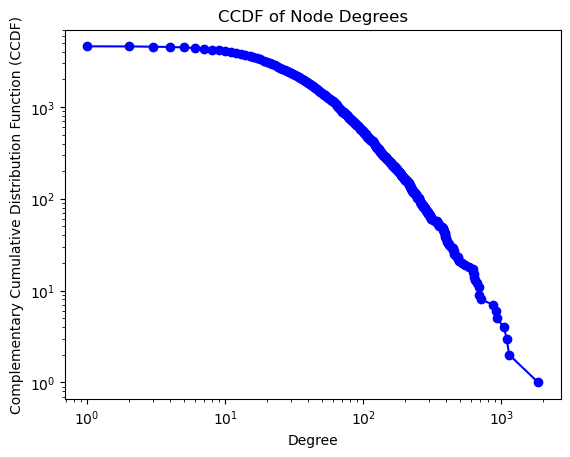

In [14]:
# Get the degrees of all nodes
degrees = dict(wikispeedia.degree())
print(degrees)
# Calculate the CCDF
degree_values = sorted(set(degrees.values()), reverse=True)
ccdf = [sum(1 for degree in degrees.values() if degree >= d) for d in degree_values]

# Plot the CCDF
plt.plot(degree_values, ccdf, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Complementary Cumulative Distribution Function (CCDF)')
plt.title('CCDF of Node Degrees')
plt.show()

What are the "hubs"? Which nodes have more than 500 links?

In [ ]:
print("Nodes with more than 1000 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 1000])
print("Nodes with more than 500 edges: ", [node for node in wikispeedia.nodes if wikispeedia.degree(node) >= 500])


Observe that biggest hubs are mainly countries. The 'United Kingdom', 'France', 'United States', and 'Europe' have over 1000 links. Since there are 4592 nodes, these nodes have link to almost 1/4 of the dataset!

How many nodes have more than 20 links? How many have only 1 link?

In [ ]:
# Count the number of nodes with degree 1
nodes_degree_1 = [node for node in wikispeedia.nodes if wikispeedia.degree(node) == 1]
print('Nodes with degree 1: ', nodes_degree_1)

# Get the percentages
total_nodes = len(wikispeedia.nodes)
percentage_degree_1 = (len(nodes_degree_1) / total_nodes)
print('% of nodes that have only 1 edge/link:', percentage_degree_1)

# Count number of nodes with degree <= 20
nodes_degree_20 = sum(1 for degree in degrees.values() if degree <= 20)
print('% of nodes that have 20 or less edges/links:', nodes_degree_20 / total_nodes)

### Let's draw the nodes with higher degree!

In [ ]:
print(degrees)
higher_degree = 300 # nodes that have at least 300 degree

Assign degree as node attribute of the wikispeedia graph

In [ ]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['degree'] = degrees[node]
print(wikispeedia.nodes(data=True))

In [ ]:
nodes_higher_degree = [n for n, data in wikispeedia.nodes(data=True) if 'degree' in data and data['degree'] >= higher_degree]
# let's sort the nodes so that we can visualize the N elements greater than average
N = 60 # to avoid extra computing time try not to establish N higher than 80
nodes_ordered_per_pagerank = sorted(nodes_higher_degree, key=lambda n: wikispeedia.nodes[n]['degree'], reverse=True)[:N]
# select this nodes from the original Wikispeedia graph 
wdegree = wikispeedia.subgraph(nodes_ordered_per_pagerank).copy()
print(wdegree)

In [ ]:
def hierarchical_layout(net):
	return graphviz_layout(net, prog="dot")

node_labels = {node: node for node in wdegree.nodes()}

pos = hierarchical_layout(wdegree)
plt.figure(figsize=(50,50))
nx.draw(wdegree,pos, node_size=[(wdegree.nodes[n]['degree'] *80) for n in wdegree], node_color='orange', font_weight='bold', with_labels=True, labels=node_labels, font_color='purple', font_size=35, linewidths=10)
plt.title('Higher Degree Nodes', fontsize=100)
plt.show()

## 3. Average Distance between Articles
On average, how many links/edges does it take to connect any random two articles?

In [ ]:
# Our graph is not strongly connected, meaning it's not possible to reach every node from every other node
# So we can't use the built in function nx.average_shortest_path_length

# This takes a long time to run (30 sec)
# shortest_paths = list(nx.all_pairs_shortest_path_length(wikispeedia))
# reachable_pairs = [(source, target, length) for source, paths in shortest_paths for target, length in paths.items() if length != float('inf')]
# total_distances = sum(length for _, _, length in reachable_pairs)
# average_distance = total_distances / len(reachable_pairs) if reachable_pairs else 0
# print(f"Average distance between reachable nodes: {average_distance:.2f}")


## 4. Games per Time
Histogram of the number of games at each point in time.


In [ ]:
# Convert timestamps to datetime objects
timestamps = paths_finished['timestamp']
date_times = [datetime.utcfromtimestamp(ts) for ts in timestamps]

# Create a histogram of timestamps
plt.hist(date_times, bins=20, color='skyblue')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Distribution of Timestamps')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

A lot of games were played in Q3 2009! 

In [ ]:
q3_2009_times = [dt for dt in date_times if dt.year == 2009 and dt.month in [7, 8, 9]]
percent_q3_2009_times = len(q3_2009_times) / len(date_times)
print(f"Percent of finished games completed in Q3 2009: {percent_q3_2009_times:.2f}")


## 5. Which categories of games are more likely to be unfinished? 

In [ ]:
categories = pd.read_csv('datasets/wikispeedia_paths-and-graph/categories.tsv', sep='\t', skiprows=12, names = ['article', 'categories'])
categories[categories['article'].duplicated()]
print('There are', categories['article'].duplicated().sum(), 'articles with more than 1 category.')

print('Should we drop the duplicate categories, or doublecount them?')
print('This corresponds to', categories['article'].duplicated().sum() / len(wikispeedia.nodes), 'of the articles.')

# Let's drop them for now.
categories['article'] = categories['article'].drop_duplicates()
categories.shape

# Why are there more articles here than nodes (# articles)?

In [ ]:
sub_categories = categories['categories'].str[8:].str.split('.')
category_depth_1 = sub_categories.apply(lambda x: x[0])
categories['depth_1'] = category_depth_1
categories.head()

In [ ]:
paths_unfinished

In [ ]:
# Let's find the category corresponding to each unfinished target
pd.merge(paths_unfinished, categories, left_on = 'target', right_on= 'article', how = 'left')

## 6. DataFrame and spreadsheet creation 

For future analysis, we may need to filter articles according to some metrics that we may have now or may create in the future. In order to speed up data handling and analysis, we will create the df and store it in a spreadsheet.

In [20]:
dic = nx.pagerank(wikispeedia)
print(dic)

{'%C3%81ed%C3%A1n_mac_Gabr%C3%A1in': 3.2710390395592254e-05, 'Bede': 0.00021938161316650256, 'Columba': 0.00012116881897593145, 'D%C3%A1l_Riata': 0.000105560154678038, 'Great_Britain': 0.0015061292462843427, 'Ireland': 0.001899965414851622, 'Isle_of_Man': 0.00046032088563309313, 'Monarchy': 0.0008133221072287704, 'Orkney': 0.00028994588516574057, 'Picts': 0.00019759121101826146, 'Scotland': 0.0021425304277849183, 'Wales': 0.001099763207428743, '%C3%85land': 3.2710390395592254e-05, '20th_century': 0.0023615390664036124, 'Baltic_Sea': 0.0006497932466591777, 'Crimean_War': 0.0002201292664638352, 'Currency': 0.0032371559196565525, 'Euro': 0.0012495337101871686, 'European_Union': 0.002318582455038707, 'Finland': 0.001009621435681574, 'League_of_Nations': 0.0005769703027683626, 'List_of_countries_by_system_of_government': 0.0028333266533963103, 'Nationality': 0.00022617861790487603, 'Parliamentary_system': 0.000721430277649281, 'Police': 0.0002528236285437583, 'Russia': 0.003496131617966406,

In [21]:
for node in [nodo for nodo in wikispeedia.nodes()]:
    wikispeedia.nodes[node]['pagerank'] = dic[node]
print(wikispeedia.nodes(data=True))

[('%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', {'pagerank': 3.2710390395592254e-05}), ('Bede', {'pagerank': 0.00021938161316650256}), ('Columba', {'pagerank': 0.00012116881897593145}), ('D%C3%A1l_Riata', {'pagerank': 0.000105560154678038}), ('Great_Britain', {'pagerank': 0.0015061292462843427}), ('Ireland', {'pagerank': 0.001899965414851622}), ('Isle_of_Man', {'pagerank': 0.00046032088563309313}), ('Monarchy', {'pagerank': 0.0008133221072287704}), ('Orkney', {'pagerank': 0.00028994588516574057}), ('Picts', {'pagerank': 0.00019759121101826146}), ('Scotland', {'pagerank': 0.0021425304277849183}), ('Wales', {'pagerank': 0.001099763207428743}), ('%C3%85land', {'pagerank': 3.2710390395592254e-05}), ('20th_century', {'pagerank': 0.0023615390664036124}), ('Baltic_Sea', {'pagerank': 0.0006497932466591777}), ('Crimean_War', {'pagerank': 0.0002201292664638352}), ('Currency', {'pagerank': 0.0032371559196565525}), ('Euro', {'pagerank': 0.0012495337101871686}), ('European_Union', {'pagerank': 0.002318582455

In [24]:
data = {}
# establish article name as index
articles_index = list(wikispeedia.nodes())
df = pd.DataFrame(data, index=articles_index)
# add main column
df['Articles'] = articles_index
df['Degree'] = degrees.values()
df['PageRank'] = dic.values()
pd.set_option('display.precision', 15) # add precision to the df
df

,Articles,Degree,PageRank
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,11,0.000032710390396
Bede,Bede,39,0.000219381613167
Columba,Columba,23,0.000121168818976
D%C3%A1l_Riata,D%C3%A1l_Riata,32,0.000105560154678
Great_Britain,Great_Britain,215,0.001506129246284
...,...,...,...
Yellowhammer,Yellowhammer,13,0.000032710390396
Yotsuya_Kaidan,Yotsuya_Kaidan,2,0.000032710390396
You%27re_Still_the_One,You%27re_Still_the_One,2,0.000032710390396
Yungay%2C_Peru,Yungay%2C_Peru,4,0.000032710390396


In [7]:
print(wikispeedia.nodes())

['%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', 'Bede', 'Columba', 'D%C3%A1l_Riata', 'Great_Britain', 'Ireland', 'Isle_of_Man', 'Monarchy', 'Orkney', 'Picts', 'Scotland', 'Wales', '%C3%85land', '20th_century', 'Baltic_Sea', 'Crimean_War', 'Currency', 'Euro', 'European_Union', 'Finland', 'League_of_Nations', 'List_of_countries_by_system_of_government', 'Nationality', 'Parliamentary_system', 'Police', 'Russia', 'Stockholm', 'Sweden', 'Time_zone', 'Tourism', 'United_Kingdom', 'World_War_II', '%C3%89douard_Manet', 'Absinthe', 'Beer', 'Claude_Monet', 'Diego_Vel%C3%A1zquez', 'Edgar_Allan_Poe', 'France', 'Francisco_Goya', 'Germany', 'Impressionism', 'Italy', 'Landscape', 'Netherlands', 'Painting', 'Paris', 'Photography', 'Raphael', 'Renaissance', 'United_States_dollar', 'Washington%2C_D.C.', '%C3%89ire', 'Canada', 'English_language', 'George_VI_of_the_United_Kingdom', 'Northern_Ireland', 'Ottawa', 'Republic_of_Ireland', '%C3%93engus_I_of_the_Picts', 'Durham', 'England', 'Lion', 'Mercia', 'Viking', 'York